**If you think this notebook deserves an upvote, I'd love to have it. An upvote per view, its all I ask**
(credit to [Dan Carlin](https://twitter.com/HardcoreHistory) for coining the phrase ;-) 

---------------------------------------

This is part of a series of notebooks about practical time series methods:

* [Part 0: the basics](https://www.kaggle.com/konradb/ts-0-the-basics)
* [Part 1a: smoothing methods](https://www.kaggle.com/konradb/ts-1a-smoothing-methods)
* [Part 1b: Prophet](https://www.kaggle.com/konradb/ts-1b-prophet) 
* [Part 2: ARMA](https://www.kaggle.com/konradb/ts-2-arma-and-friends)
* [Part 3: Time series for finance](https://www.kaggle.com/konradb/ts-3-time-series-for-finance) 
* [Part 4: Sales and demand forecasting](https://www.kaggle.com/konradb/ts-4-sales-and-demand-forecasting)
* [Part 5: Automatic for the people](https://www.kaggle.com/code/konradb/ts-5-automatic-for-the-people) - **this notebook**
* [Part 6: Deep learning for TS - sequences](https://www.kaggle.com/konradb/ts-6-deep-learning-for-ts-sequences) 
* [Part 7: Survival analysis](https://www.kaggle.com/code/konradb/ts-7-survival-analysis)
* [Part 8: Hierarchical time series](https://www.kaggle.com/code/konradb/ts-8-hierarchical-time-series)
* [Part 9: Hybrid methods](https://www.kaggle.com/code/konradb/ts-9-hybrid-methods/)
* [Part 10: Validation methods for time series](https://www.kaggle.com/code/konradb/ts-10-validation-methods-for-time-series/)
* [Part 11: Transfer learning](https://www.kaggle.com/code/konradb/ts-11-deep-learning-for-ts-transfer-learning)


The series is accompanied by video presentations on the YouTube channel of [Abhishek](https://www.kaggle.com/abhishek):

* [Talk 0](https://www.youtube.com/watch?v=cKzXOOtOXYY) 
* [Talk 1](https://www.youtube.com/watch?v=kAI67Sz92-s) - combining the content from parts 1a and 1b
* [Talk 2](https://www.youtube.com/watch?v=LjV5DE3KR-U) 
* [Talk 3](https://www.youtube.com/watch?v=74rDhJexmTg)
* [Talk 4](https://www.youtube.com/watch?v=RdH8zd07u2E) 
* [Talk 5](https://www.youtube.com/watch?v=wBP8Pc4Wxzs) - **based on this notebook**
* [Talk 6](https://www.youtube.com/watch?v=81AEI0tj0Kk)
* [Talk 7](https://www.youtube.com/watch?v=m-8I_hkmz9o)
* [Talk 8](https://www.youtube.com/watch?v=7ZTarg4QYR4)
* [Talk 9](https://www.youtube.com/watch?v=NYZzBvKcfp4)
* [Talk 10](https://www.youtube.com/watch?v=47WeBiLV2Uo)
* [Talk 11]()


---------------------------------------


In the previous installments of this series, we discussed fundamental concepts from time series analysis, as well as vintage methods like exponential smoothing and the ARIMA family. In this one, we focus on the idea of a one stop shop for time series analysis: in the last few years, several packages have appeared that position themselves in such a fashion. We will take them for a test drive and have a look at how close they come to fulfilling the promise. Each of the packages implementing the "automatic for the people" philosophy for time series has it own dedicated section below:

* [AutoTS](#section-one)
* [Darts](#section-two)
* [Kats](#section-three)
* [Bonus track: GluonTS](#section-four) 

Disclaimer: since the packages we use are somewhat experimental (and as such, not part of the Kaggle Docker image), we will need to install each of them separately in their respective sections.

In [1]:
import itertools
import pandas as pd
import numpy as np
from random import gauss

from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Ridge 

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [2]:
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
    #  for faster iteration / execution
    cutoff = '2018-01-01'        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   

In [3]:
# helper functions
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

For the sake of a meaningful comparison, we will stick to the same dataset across different models and revisit the Nifty-50 data we used in the ARIMA episode https://www.kaggle.com/code/konradb/ts-2-linear-vision.


<AxesSubplot:>

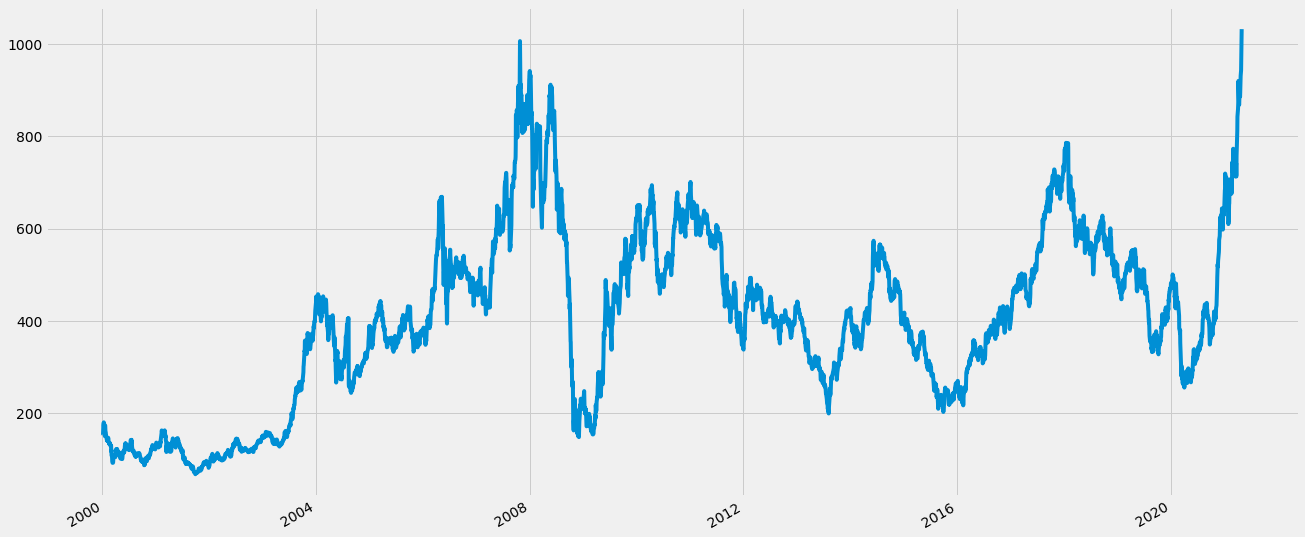

In [4]:
stock_name = 'TATASTEEL'

# load the data
df = pd.read_csv('../input/nifty50-stock-market-data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",  inplace=True)
df.VWAP.plot(xlabel = '')



In [5]:
# split into training / validation
df_train, df_test = df.iloc[df.index <= '2021-01-01'], df.iloc[df.index > '2021-01-01']
print(df_train.shape, df_test.shape)



(5227, 1) (79, 1)


<a id="section-one"></a>
# AutoTS


Auto-TS is the closest we have in applying the AutoML philosophy specifically to time series. Primary features include:

* finding an optimal time series forecasting model using genetic programming optimization
* training diverse models
* data transformations 
* combination of metrics for model selection

In [6]:
!pip install autots

     |████████████████████████████████| 529 kB 778 kB/s            


In [7]:
from autots.models.model_list import model_lists
from autots import AutoTS

First thing we do: which models are available to play with? The possible candidate models are grouped into several (overlapping!) classes:

In [8]:
model_lists.keys()

dict_keys(['all', 'default', 'fast', 'superfast', 'parallel', 'fast_parallel', 'probabilistic', 'multivariate', 'univariate', 'no_params', 'recombination_approved', 'no_shared', 'no_shared_fast', 'experimental', 'slow', 'gpu', 'regressor', 'best', 'motifs'])

In [9]:
# full list of models:
model_lists['all']

['ConstantNaive',
 'LastValueNaive',
 'AverageValueNaive',
 'GLS',
 'GLM',
 'ETS',
 'ARIMA',
 'FBProphet',
 'RollingRegression',
 'GluonTS',
 'SeasonalNaive',
 'UnobservedComponents',
 'VARMAX',
 'VECM',
 'DynamicFactor',
 'MotifSimulation',
 'WindowRegression',
 'VAR',
 'DatepartRegression',
 'UnivariateRegression',
 'Greykite',
 'UnivariateMotif',
 'MultivariateMotif',
 'NVAR',
 'MultivariateRegression',
 'SectionalMotif',
 'Theta',
 'ARDL',
 'NeuralProphet',
 'DynamicFactorMQ',
 'PytorchForecasting',
 'ARCH',
 'RRVAR',
 'MAR',
 'TMF',
 'LATC']

In [10]:
model_lists['fast']

{'ConstantNaive': 1,
 'LastValueNaive': 1.5,
 'AverageValueNaive': 1,
 'GLS': 1,
 'SeasonalNaive': 1,
 'GLM': 1,
 'ETS': 1,
 'VAR': 0.8,
 'VECM': 1,
 'WindowRegression': 0.5,
 'DatepartRegression': 0.8,
 'UnivariateMotif': 1,
 'MultivariateMotif': 0.8,
 'SectionalMotif': 1,
 'NVAR': 1,
 'MAR': 1,
 'RRVAR': 1}

In [11]:
model_lists['superfast']

['ConstantNaive',
 'LastValueNaive',
 'AverageValueNaive',
 'GLS',
 'SeasonalNaive']

In [12]:
model_lists['probabilistic']

['ARIMA',
 'GluonTS',
 'FBProphet',
 'AverageValueNaive',
 'VARMAX',
 'DynamicFactor',
 'VAR',
 'UnivariateMotif',
 'MultivariateMotif',
 'SectionalMotif',
 'NVAR',
 'Theta',
 'ARDL',
 'UnobservedComponents',
 'DynamicFactorMQ',
 'PytorchForecasting',
 'ARCH']

There are quite a few models to choose from (most of which weren't discussed before), but we focus on one: 
- the Theta method was proposed in 2000: https://www.researchgate.net/publication/223049702_The_theta_model_A_decomposition_approach_to_forecasting
- regression on time + exponential smoothing
- degrees of damping the trend via $\theta$
- de/reseasonalize


OLS: 

\begin{equation}
    X_t = a_0 + b_0 (t-1) + \epsilon_t 
\end{equation}


SES:
\begin{equation}
S_t = (1 - \alpha) X_t + \alpha S_{t-1}
\end{equation}


Forecast:
\begin{equation}
\hat{X}_{T+h|T} = \frac{\theta - 1}{\theta} b_0 \left[h - 1 + \frac{1}{\alpha} - \frac{(1 - \alpha)^T}{\alpha} \right] + S_{T+h | T}
\end{equation}


Specify the model parameters:

In [13]:
# specify the model
model = AutoTS(
    forecast_length = len(df_test),
    frequency='infer',
    prediction_interval=0.9,
    ensemble=  'simple' , # select single best model
    # we want some results, but also execution in reasonable time
    # GA ARE SLOW
    model_list =  ['GLM', 'Theta', 'ETS'], 
    transformer_list="superfast",  
    drop_most_recent=1,
    max_generations=5,
    num_validations=2,
    validation_method = "backwards"
)


# fit the model
model = model.fit(
    df_train,
#     date_col= None, # 'datetime' if long else None,
#     value_col= None,#  'value' if long else None,
#     id_col= None,   #'series_id' if long else None,
)

Inferred frequency is: B
Model Number: 1 with model ETS in generation 0 of 5
Model Number: 2 with model ETS in generation 0 of 5
Model Number: 3 with model GLM in generation 0 of 5
Model Number: 4 with model GLM in generation 0 of 5
Model Number: 5 with model ETS in generation 0 of 5
Model Number: 6 with model Theta in generation 0 of 5
Model Number: 7 with model GLM in generation 0 of 5
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 7: GLM
Model Number: 8 with model Theta in generation 0 of 5


/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 9 with model ETS in generation 0 of 5
Model Number: 10 with model Theta in generation 0 of 5
Model Number: 11 with model GLM in generation 0 of 5
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 11: GLM
Model Number: 12 with model GLM in generation 0 of 5
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 12: GLM
Model Number: 13 with model Theta in generation 0 of 5


/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 14 with model Theta in generation 0 of 5
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 14: Theta
Model Number: 15 with model ETS in generation 0 of 5
Model Number: 16 with model Theta in generation 0 of 5
Model Number: 17 with model GLM in generation 0 of 5
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 17: GLM
Model Number: 18 with model ETS in generation 0 of 5


/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:426: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 19 with model ETS in generation 0 of 5
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on VWAP with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 20 with model GLM in generation 0 of 5
Model Number: 21 with model Theta in generation 0 of 5
New Generation: 1 of 5
Model Number: 22 with model ETS in generation 1 of 5
Model Number: 23 with model Theta in generation 1 of 5
Model Number: 24 with model ETS in generation 1 of 5
Model Number: 25 with model ETS in generation 1 of 5
Model Number: 26 with model Theta in generation 1 of 5
Model Number: 27 with model Theta in generation 1 of 5
Model Number: 28 with model Theta in generation 1 of 5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.81641D+0

 This problem is unconstrained.



At iterate    5    f= -1.81675D+00    |proj g|=  5.60307D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   5.603D-07  -1.817D+00
  F =  -1.8167475540816702     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model Number: 29 with model ETS in generation 1 of 5
Model Number: 30 with model ETS in generation 1 of 5
Model Number: 31 with model Theta in generation 1 of 5
Model Number: 32 with model Theta in generation 1 of 5
Model Number: 33 with model ETS in generation 1 of 5
Model Number: 34 with model ETS in generation 1 of 5
Model Number: 35 with model GLM in gene

/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:301: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


Model Number: 36 with model ETS in generation 1 of 5
New Generation: 2 of 5
Model Number: 37 with model GLM in generation 2 of 5
Model Number: 38 with model Theta in generation 2 of 5
Model Number: 39 with model Theta in generation 2 of 5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.30476D+00    |proj g|=  1.39173D+00


 This problem is unconstrained.



At iterate    5    f= -2.30503D+00    |proj g|=  1.06137D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   1.061D-06  -2.305D+00
  F =  -2.3050311093185489     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model Number: 40 with model Theta in generation 2 of 5
Model Number: 41 with model Theta in generation 2 of 5
Model Number: 42 with model ETS in generation 2 of 5
Model Number: 43 with model ETS in generation 2 of 5
Model Number: 44 with model Theta in generation 2 of 5
Model Number: 45 with model Theta in generation 2 of 5
RUNNING THE L-BFGS-B CODE

        

 This problem is unconstrained.


Model Number: 46 with model Theta in generation 2 of 5
Model Number: 47 with model ETS in generation 2 of 5
Model Number: 48 with model Theta in generation 2 of 5
Model Number: 49 with model ETS in generation 2 of 5
Model Number: 50 with model Theta in generation 2 of 5
Model Number: 51 with model Theta in generation 2 of 5
New Generation: 3 of 5
Model Number: 52 with model GLM in generation 3 of 5


/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:516: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:426: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:132: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:1212: RuntimeWarning: invalid value encountered in multiply
  - self._offset_exposure)


Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 52: GLM
Model Number: 53 with model Theta in generation 3 of 5
Model Number: 54 with model GLM in generation 3 of 5


/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:301: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


Model Number: 55 with model ETS in generation 3 of 5
Model Number: 56 with model ETS in generation 3 of 5
Model Number: 57 with model Theta in generation 3 of 5
Model Number: 58 with model Theta in generation 3 of 5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70553D+00    |proj g|=  3.66939D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.516D-06   3.705D+00
  F =   3.7052224772184261     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT

 This problem is unconstrained.


Model Number: 59 with model Theta in generation 3 of 5


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67791D+00    |proj g|=  5.01858D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   4.280D-06   3.677D+00
  F =   3.6773713193198665     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model Number: 60 with model GLM in generation 3 of 5
Model Number: 61 with model Theta in generation 3 of 5
Model Number: 62 with model GLM in generation 3 of 5
Template Eval Error: ValueError('

/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:516: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:426: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:132: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:1212: RuntimeWarning: invalid value encountered in multiply
  - self._offset_exposure)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70553D+00    |proj g|=  3.66939D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.516D-06   3.705D+00
  F =   3.7052224772184261     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


Model Number: 64 with model ETS in generation 3 of 5
Model Number: 65 with model ETS in generation 3 of 5
Model Number: 66 with model Theta in generation 3 of 5
New Generation: 4 of 5
Model Number: 67 with model ETS in generation 4 of 5
Model Number: 68 with model Theta in generation 4 of 5
Model Number: 69 with model Theta in generation 4 of 5
Model Number: 70 with model GLM in generation 4 of 5
Model Number: 71 with model Theta in generation 4 of 5
Model Number: 72 with model GLM in generation 4 of 5
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 72: GLM
Model Number: 73 with model Theta in generation 4 of 5


/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:426: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 74 with model ETS in generation 4 of 5
Model Number: 75 with model GLM in generation 4 of 5


/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:301: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:318: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:740: RuntimeWarning: invalid value encountered in true_divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
/opt/conda/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:804: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
/opt/conda/lib/python3.7/site-pa

Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 75: GLM
Model Number: 76 with model Theta in generation 4 of 5
Model Number: 77 with model Theta in generation 4 of 5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27295D+00    |proj g|=  7.87110D-02

At iterate    5    f=  3.23977D+00    |proj g|=  1.21236D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      6      1     0     0   1.212D-08   3.24

 This problem is unconstrained.


Model Number: 78 with model GLM in generation 4 of 5
Model Number: 79 with model ETS in generation 4 of 5
Model Number: 80 with model Theta in generation 4 of 5
Model Number: 81 with model Theta in generation 4 of 5
New Generation: 5 of 5
Model Number: 82 with model ETS in generation 5 of 5
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on VWAP with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 83 with model Theta in generation 5 of 5
Model Number: 84 with model Theta in generation 5 of 5
Model Number: 85 with model Theta in generation 5 of 5
Model Number: 86 with model Theta in generation 5 of 5
Model Number: 87 with model ETS in generation 5 of 5
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on VWAP with ValueError('endog must be strictly positive when usingmultiplica

 This problem is unconstrained.



At iterate    5    f= -2.30503D+00    |proj g|=  1.06137D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   1.061D-06  -2.305D+00
  F =  -2.3050311093185489     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model Number: 96 with model Ensemble in generation 6 of Ensembles
Model Number: 97 with model Ensemble in generation 6 of Ensembles
Model Number: 98 with model Ensemble in generation 6 of Ensembles
Model Number: 99 with model Ensemble in generation 6 of Ensembles
Model Number: 100 with model Ensemble in generation 6 of Ensembles
Validation Round: 1
Model Numb

 This problem is unconstrained.



At iterate    5    f= -2.30346D+00    |proj g|=  1.50773D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   1.508D-06  -2.303D+00
  F =  -2.3034583321222413     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
3 - Ensemble with avg smape 25.94: 
Model Number: 4 of 15 with model ETS for Validation 1
Template Eval Error: ValueError('Model ETS returned NaN for one or more series. fail_on_forecast_nan=True') in model 4: ETS
Model Number: 5 of 15 with model Ensemble for Validation 1
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/autots

 This problem is unconstrained.



At iterate    5    f= -2.30346D+00    |proj g|=  1.50773D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   1.508D-06  -2.303D+00
  F =  -2.3034583321222413     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
8 - Theta with avg smape 26.28: 
Model Number: 9 of 15 with model Theta for Validation 1
9 - Theta with avg smape 25.52: 
Model Number: 10 of 15 with model Theta for Validation 1
10 - Theta with avg smape 26.14: 
Model Number: 11 of 15 with model Ensemble for Validation 1
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/autots

 This problem is unconstrained.



At iterate    5    f= -2.31229D+00    |proj g|=  4.69016D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   4.690D-06  -2.312D+00
  F =  -2.3122896984839363     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
3 - Ensemble with avg smape 34.35: 
Model Number: 4 of 15 with model ETS for Validation 2
4 - ETS with avg smape 37.2: 
Model Number: 5 of 15 with model Ensemble for Validation 2
5 - Ensemble with avg smape 32.94: 
Model Number: 6 of 15 with model Theta for Validation 2
📈 6 - Theta with avg smape 31.47: 
Model Number: 7 of 15 with model Theta for Validation 2

 This problem is unconstrained.



At iterate    5    f= -2.31229D+00    |proj g|=  4.69016D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   4.690D-06  -2.312D+00
  F =  -2.3122896984839363     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
8 - Theta with avg smape 34.35: 
Model Number: 9 of 15 with model Theta for Validation 2
9 - Theta with avg smape 31.52: 
Model Number: 10 of 15 with model Theta for Validation 2
10 - Theta with avg smape 34.4: 
Model Number: 11 of 15 with model Ensemble for Validation 2
11 - Ensemble with avg smape 32.58: 
Model Number: 12 of 15 with model Ensemble for Valid

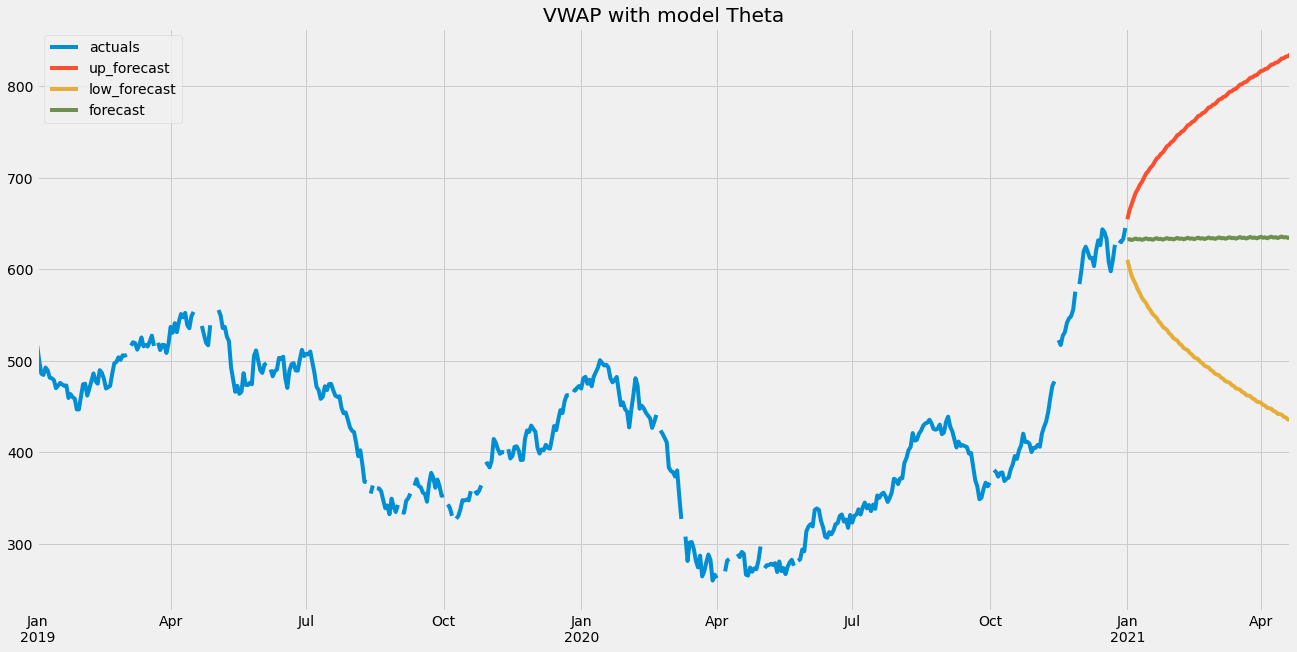

In [14]:
# generate prediction
prediction = model.predict()
# plot a sample
prediction.plot(model.df_wide_numeric,
                series=model.df_wide_numeric.columns[0],
                start_date="2019-01-01")

In [15]:
# Print the details of the best model
print(model)

Initiated AutoTS object with best model: 
Theta
{'fillna': 'rolling_mean_24', 'transformations': {'0': 'bkfilter'}, 'transformation_params': {'0': {}}}
{'deseasonalize': True, 'difference': False, 'use_test': True, 'method': 'auto', 'period': None, 'theta': 2.5, 'use_mle': False}
SMAPE: 18.83035825385489, 25.86318121348524, 31.48243513898438
MAE: 91.65064408571624, 85.68986854593564, 112.9309256197481
SPL: 5.595835311753522, 3.177263664866843, 4.809821171113177


In [16]:
# point forecasts 
forecasts_df = prediction.forecast

# upper and lower forecasts
forecasts_up, forecasts_low = prediction.upper_forecast, prediction.lower_forecast


In [17]:
# quality of all tried model results
model_results = model.results()
model_results.head(3)

ID Model  \
0  fc88eb52260a48e4849caa581f4a956a   ETS   
1  14b3db37578d8ef10cd944886e631dfc   ETS   
2  f9165705030a1b5defa914d3f8ab7945   GLM   

                                     ModelParameters  \
0  {"damped_trend": false, "trend": "additive", "...   
1  {"damped_trend": false, "trend": null, "season...   
2  {"family": "Binomial", "constant": false, "reg...   

                            TransformationParameters  TransformationRuntime  \
0  {"fillna": "mean", "transformations": {"0": "C... 0 days 00:00:00.005743   
1  {"fillna": "rolling_mean", "transformations": ... 0 days 00:00:00.017333   
2  {"fillna": "ffill_mean_biased", "transformatio... 0 days 00:00:00.006437   

              FitRuntime         PredictRuntime           TotalRuntime  \
0 0 days 00:00:00.000050 0 days 00:00:00.528429 0 days 00:00:00.543271   
1 0 days 00:00:00.000073 0 days 00:00:00.414238 0 days 00:00:00.439148   
2 0 days 00:00:00.000058 0 days 00:00:00.574975 0 days 00:00:00.588634   

   Ensemble Exceptions  ...  mle_weighted  imle_weighted  spl_weighted  \
0         0        NaN  ...     62.581328      23.032645      9.825531   
1         0        NaN  ...     82.345970      13.214384      9.097852   
2         0        NaN  ...    478.949200       6.150612     29.207653   

   containment_weighted  contour_weighted  maxe_weighted  oda_weighted  \
0              0.949367          0.670886     187.366113      0.569620   
1              0.949367          0.443038     234.253171      0.569620   
2              0.063291          0.329114     644.140000      0.379747   

   mqae_weighted  TotalRuntimeSeconds       Score  
0      70.053125               0.5433   30.677156  
1      75.823881               0.4391   32.839503  
2     460.307015               0.5886  176.185530  

[3 rows x 41 columns]

In [18]:
# performance
my_rmse(forecasts_df, df_test.VWAP)

155.5147

`AutoTS` summary:
* minimalistic setup - but tinkering possible
* cornucopia of (univariate) models
* GA is **slow**
* very much beta version

<a id="section-two"></a>
# Darts

An interesting example of a library combining multiple time series models is `darts` https://unit8co.github.io/darts/ . It takes a slightly different approach then AutoTS: instead of automatically combining a set of models from a predefined list, it allows us to setup evaluation of different models in standardized manner.

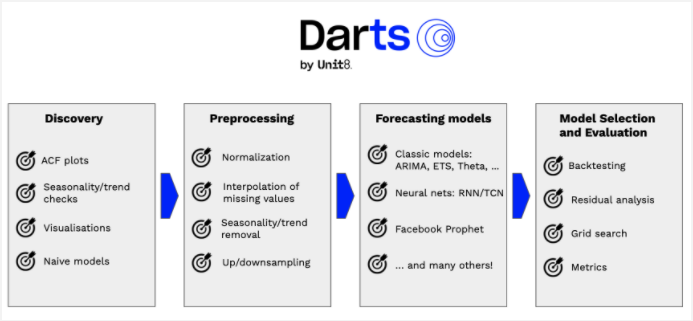

The list of possible candidate models is quite exhaustive:

* ARIMA
* Auto-ARIMA
* Baseline Models
* Block Recurrent Neural Networks
* Exponential Smoothing
* Fast Fourier Transform
* LightGBM Model
* Linear Regression model
* N-BEATS
* Facebook Prophet
* Random Forest
* Regression ensemble model
* Regression Model
* Recurrent Neural Networks
* Temporal Convolutional Network
* Temporal Fusion Transformer (TFT)
* Theta Method
* Transformer Model
* VARIMA

This package and `Kats` discussed in the next section have certain overlap in their focus, so in order to avoid redundancy we will take something of an *a la carte* approach.

In [19]:
!pip install llvmlite --ignore-installed

     |████████████████████████████████| 34.6 MB 219 kB/s            
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.54.1 requires llvmlite<0.38,>=0.37.0rc1, but you have llvmlite 0.39.1 which is incompatible.


In [20]:
!pip install darts[all]

     |████████████████████████████████| 424 kB 916 kB/s            
     |████████████████████████████████| 1.8 MB 20.8 MB/s            
     |████████████████████████████████| 43 kB 1.3 MB/s             
     |████████████████████████████████| 8.9 MB 69.3 MB/s            
     |████████████████████████████████| 76.8 MB 20 kB/s              
     |████████████████████████████████| 44 kB 1.6 MB/s             
     |████████████████████████████████| 9.8 MB 35.7 MB/s            
     |████████████████████████████████| 15.7 MB 51.0 MB/s            
     |████████████████████████████████| 80 kB 7.6 MB/s             
     |████████████████████████████████| 184 kB 66.1 MB/s            
     |████████████████████████████████| 26.3 MB 57.4 MB/s            
     |████████████████████████████████| 3.5 MB 34.4 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall

## Backtesting

In [21]:
!python -m pip install prophet


In [22]:
from darts import TimeSeries
from darts.models import Prophet, ExponentialSmoothing, AutoARIMA, Theta, RegressionEnsembleModel, RegressionModel

In this section we will focus on a very useful feature of `darts`: backtesting. A frequent approach to validation of time series models is to split the data on time: training set are all the observations up to some timepoint $t_0$ and validation is the part afterwards. While simple to set up, this approach runs the risk of overfitting to our chosen validation set. The `historical_forecast` method built into all the models in `darts` solves this problem by allowing us to perform a walk-forward validation:

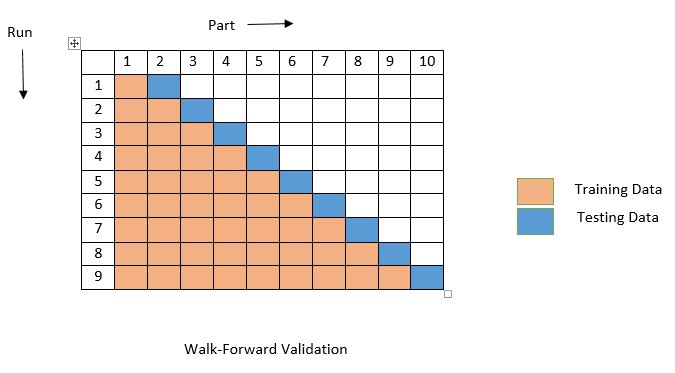

For the visually challenged people like me:
* we use an expanding training window
* for each run, we train the model on the training set and generate a forecast on test
* next run has an extended training set and a shifted test

Let's take some of the already familiar models, as well as a few new ones for a ride. First, we borrow a helpful wrapper function from the official documentation:

In [23]:
from darts.metrics import rmse 

def eval_model(model, flow,
               past_covariates=None,  future_covariates=None,
              retrain = False,
              forecast_horizon = 10,
              last_obs = 200):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, 
    # with a horizon of `forecast_horizon` steps:
    backtest = model.historical_forecasts(series=flow, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.8, 
                                          retrain=retrain,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon)
    
    flow[-len(backtest) - last_obs:].plot()
    backtest.plot(label='backtest (n=' + str(forecast_horizon) + ')')
    
    print('Backtest RMSE = {}'.format(np.round( rmse(flow, backtest) )))

Format the data into `darts` format:

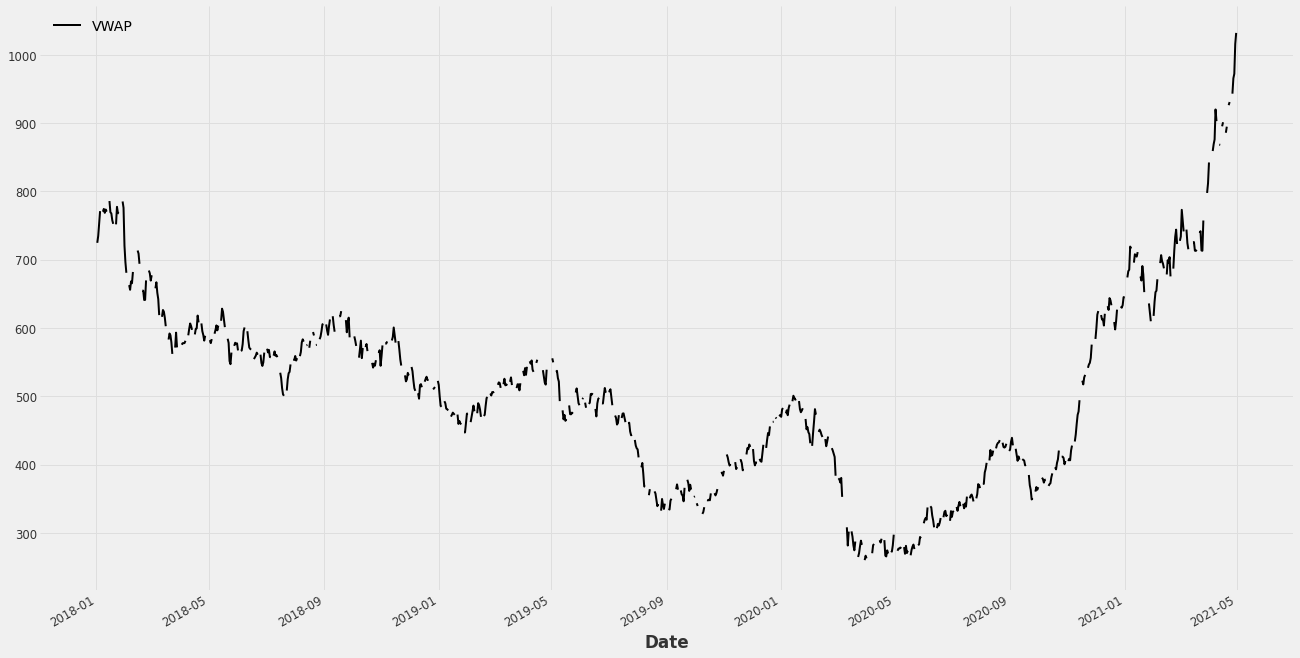

In [24]:
stock_names = 'TATAMOTORS'
df = pd.read_csv('../input/nifty50-stock-market-data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
df = df.loc[df.Date > CFG.cutoff]
series = TimeSeries.from_dataframe(df, 'Date', 'VWAP', freq = 'D')
series.plot()
# df.set_index('Date').VWAP.plot()

We begin with exponential smoothing - for a refresher see https://www.kaggle.com/code/konradb/ts-1a-smoothing-methods

In [25]:
# ExponentialSmoothing can't handle NAs :-(
from darts.utils.missing_values import fill_missing_values
series = fill_missing_values(series)

# split into training / validation
train, val = series[:-60], series[-60:]

  0%|          | 0/226 [00:00<?, ?it/s]

Backtest RMSE = 31.0


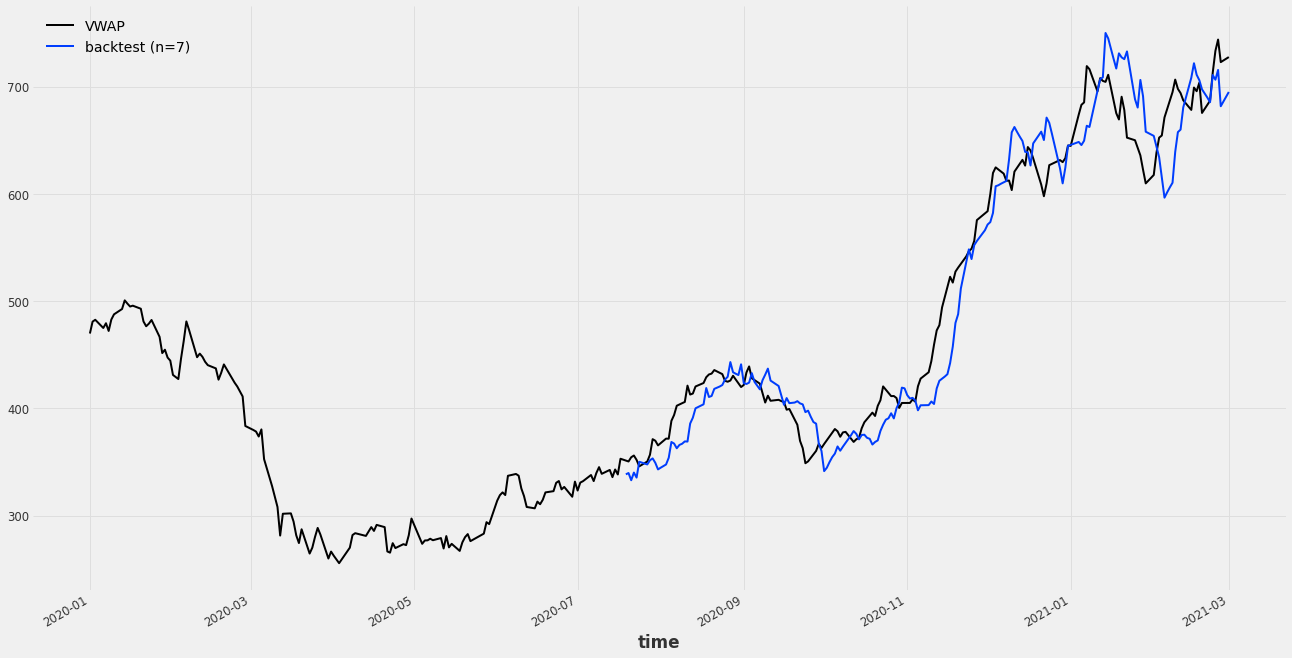

In [26]:
model = ExponentialSmoothing()
eval_model(model, flow = train, 
           retrain = True,   forecast_horizon = 7)

  0%|          | 0/218 [00:00<?, ?it/s]

Backtest RMSE = 55.0


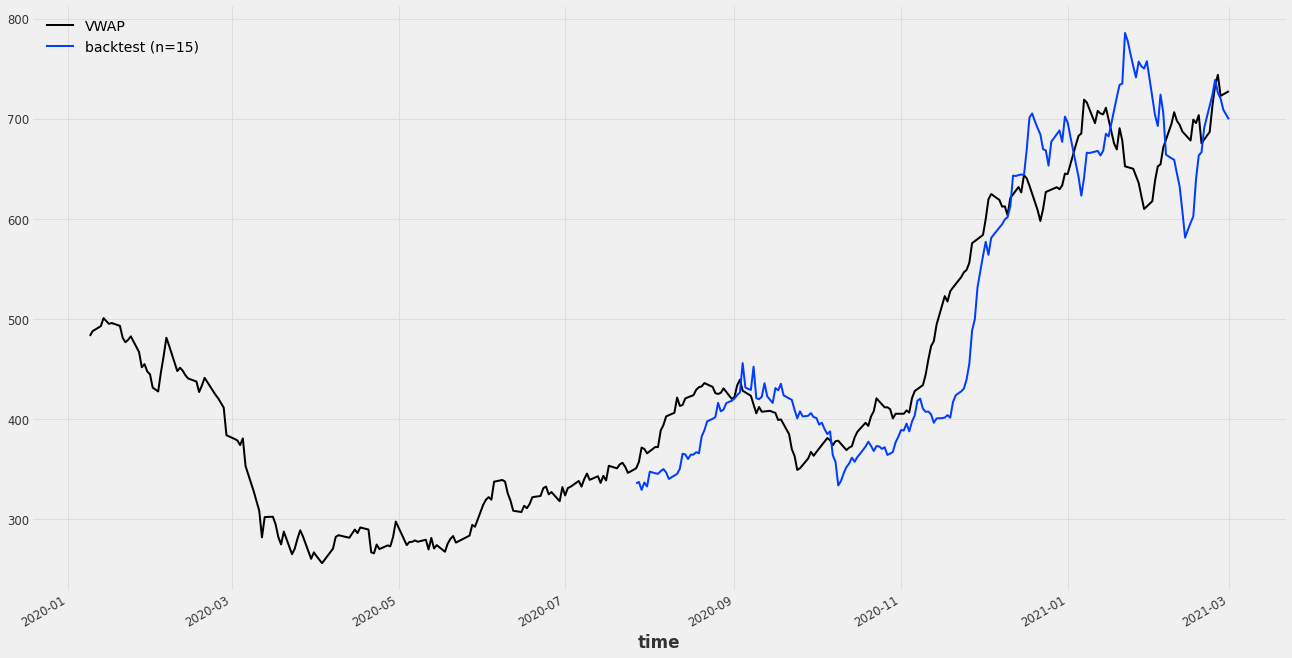

In [27]:
eval_model(model, flow = train, retrain = True, forecast_horizon = 15)

  0%|          | 0/203 [00:00<?, ?it/s]

Backtest RMSE = 91.0


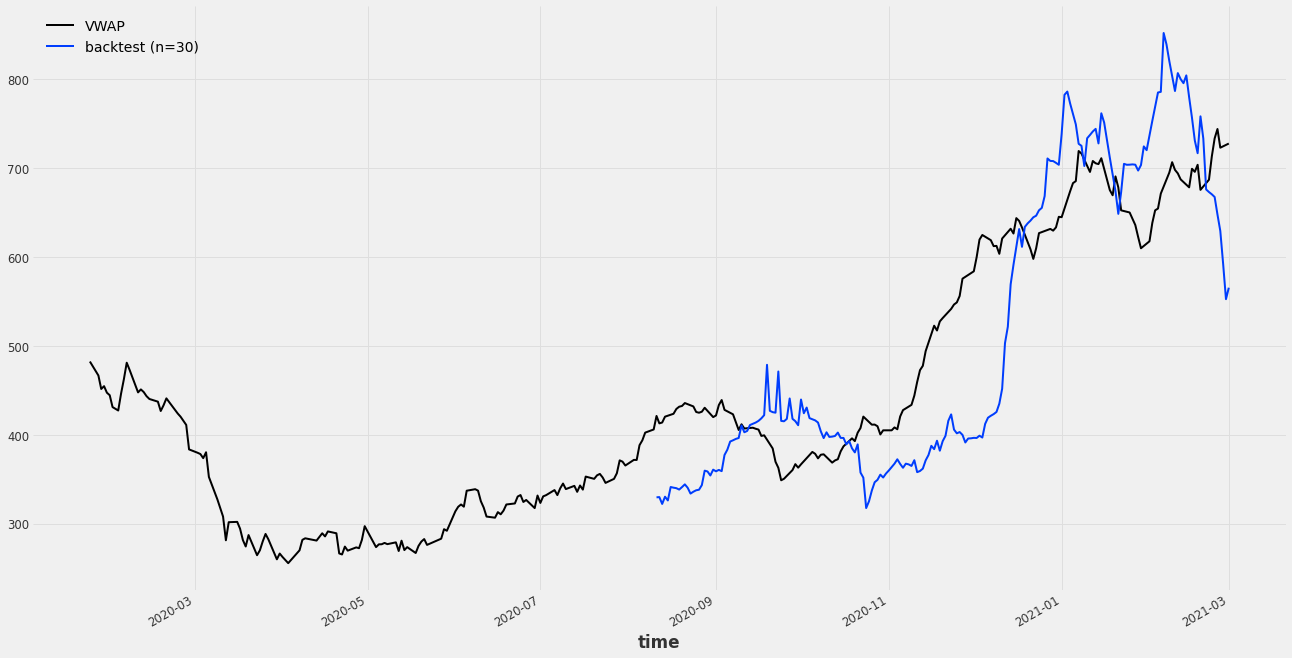

In [28]:
eval_model(model, flow = train, retrain = True, forecast_horizon = 30)

Next: Prophet, which `darts` also wraps (see https://www.kaggle.com/code/konradb/ts-1b-prophet if you missed that episode ;-) Not surprisingly, the backstesting - even at default parameters - takes a little longer than before.

  0%|          | 0/226 [00:00<?, ?it/s]

12:55:32 - cmdstanpy - INFO - Chain [1] start processing
12:55:32 - cmdstanpy - INFO - Chain [1] done processing
12:55:33 - cmdstanpy - INFO - Chain [1] start processing
12:55:34 - cmdstanpy - INFO - Chain [1] done processing
12:55:34 - cmdstanpy - INFO - Chain [1] start processing
12:55:35 - cmdstanpy - INFO - Chain [1] done processing
12:55:35 - cmdstanpy - INFO - Chain [1] start processing
12:55:36 - cmdstanpy - INFO - Chain [1] done processing
12:55:37 - cmdstanpy - INFO - Chain [1] start processing
12:55:37 - cmdstanpy - INFO - Chain [1] done processing
12:55:38 - cmdstanpy - INFO - Chain [1] start processing
12:55:38 - cmdstanpy - INFO - Chain [1] done processing
12:55:39 - cmdstanpy - INFO - Chain [1] start processing
12:55:40 - cmdstanpy - INFO - Chain [1] done processing
12:55:40 - cmdstanpy - INFO - Chain [1] start processing
12:55:41 - cmdstanpy - INFO - Chain [1] done processing
12:55:42 - cmdstanpy - INFO - Chain [1] start processing
12:55:42 - cmdstanpy - INFO - Chain [1]

Backtest RMSE = 53.0


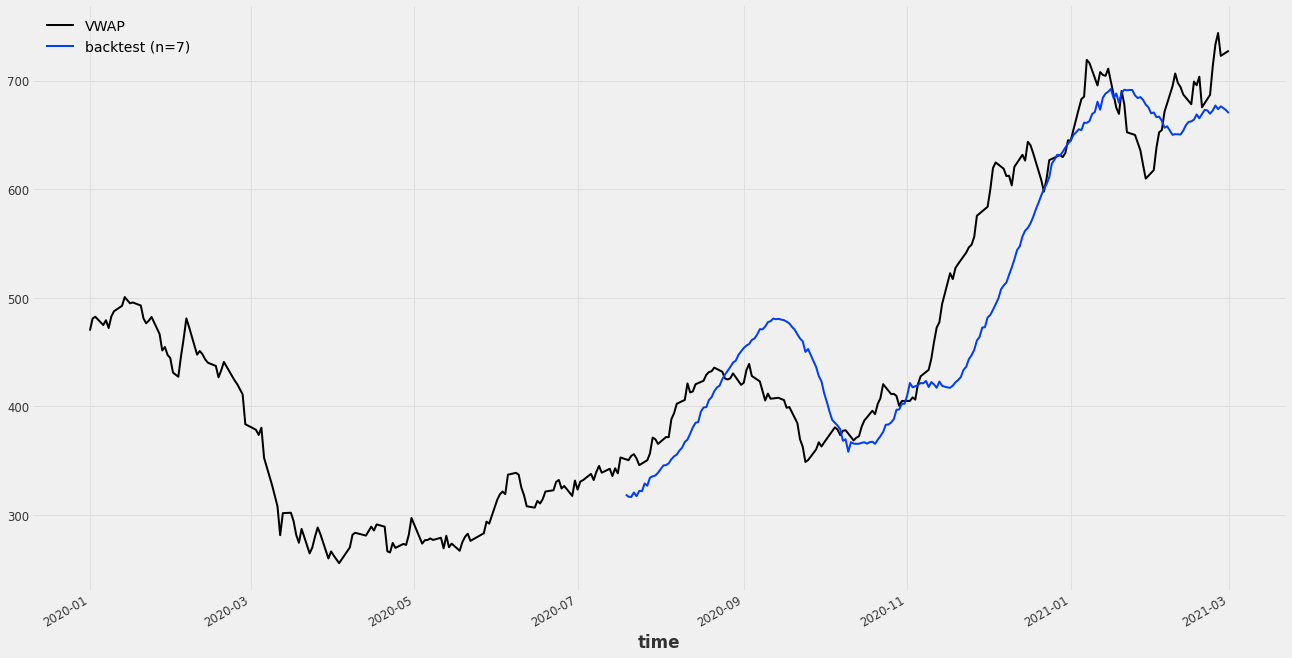

In [29]:
df = pd.read_csv('../input/nifty50-stock-market-data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
df = df.loc[df.Date > CFG.cutoff]

series = TimeSeries.from_dataframe(df, 'Date', 'VWAP', freq = 'D')

model = Prophet()
eval_model(model, flow = train, retrain = True, forecast_horizon = 7)

No overview of vintage methods would be complete without ARIMA https://www.kaggle.com/code/konradb/ts-2-linear-vision

  0%|          | 0/226 [00:00<?, ?it/s]

Backtest RMSE = 31.0


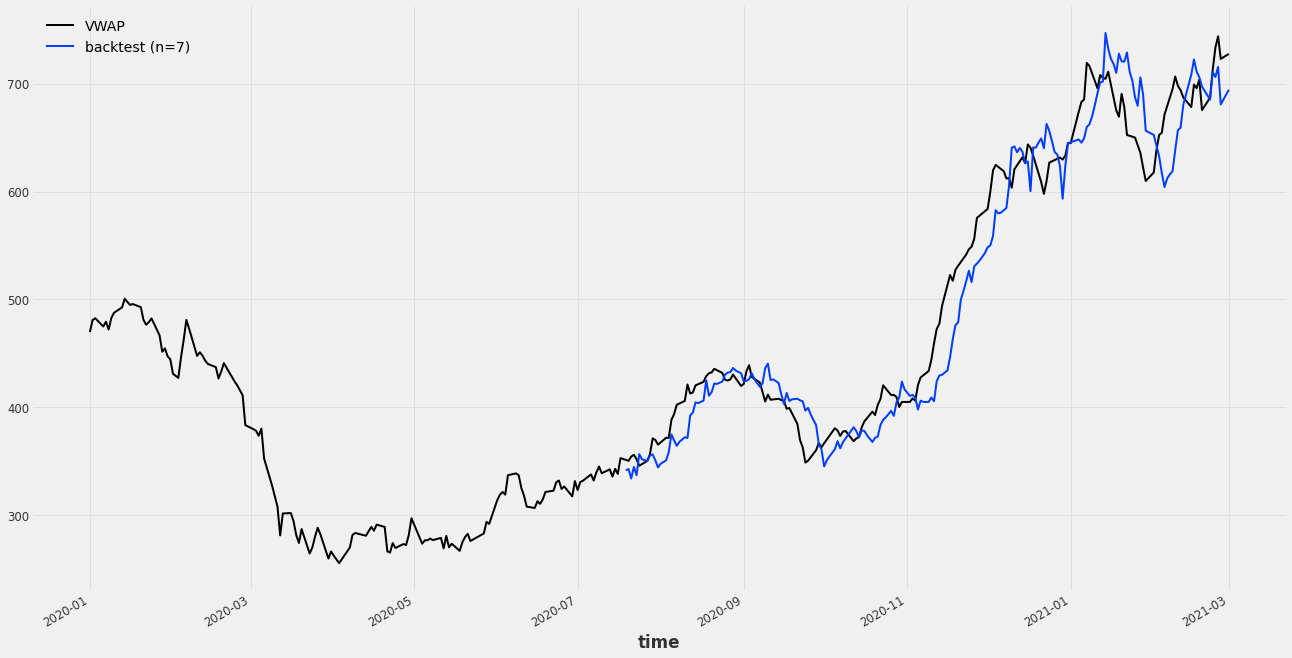

In [30]:
df = pd.read_csv('../input/nifty50-stock-market-data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
df = df.loc[df.Date > CFG.cutoff]

series = TimeSeries.from_dataframe(df, 'Date', 'VWAP', freq = 'D')
series = fill_missing_values(series)

model = AutoARIMA()
eval_model(model, flow = train, retrain = True, forecast_horizon = 7)

An interesting feature of `darts` is that unlike some other packages, we can use deep learning models in exact same manner. The package can incorporate different DL architectures (RNN, LSTM, Transformers) as well as hybrid approaches (N-Beats). Since this is our first venture into the #DeepLearnEverything space, let's start with the basics and fit an RNN:
- the first DL architecture focus on sequential data
- memory (vs LSTM)
- will get a full episode of their own ;-) 

In [31]:
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel

df = pd.read_csv('../input/nifty50-stock-market-data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
df = df.loc[df.Date > CFG.cutoff]

series = TimeSeries.from_dataframe(df, 'Date', 'VWAP', freq = 'D')
series = fill_missing_values(series)

# split into training / validation
train, val = series[:-60], series[-60:]

transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)


# scale
model = RNNModel(
    model="RNN",
    hidden_dim=20, dropout=0,  batch_size=16, n_epochs= 10, optimizer_kwargs={"lr": 1e-3},
    model_name="muh_RNN", log_tensorboard=True, random_state=42, training_length=20,    
    input_chunk_length=14,
    
    force_reset=True,
    save_checkpoints=True,
)

In [32]:
# eval_model(model, flow = train_transformed, retrain = True, forecast_horizon = 7)
# sadly, workaround needed to due my failure to suppress
# pages and pages of warnings
backtest = model.historical_forecasts(series=train_transformed, 
                                          past_covariates= None,
                                          future_covariates=None,
                                          start=0.8,  retrain=True, verbose=True, 
                                          forecast_horizon=7)

  0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:644: UserWarning: ModelCheckpoint(monitor='val_loss') not found in the returned metrics: ['train_loss']. HINT: Did you call self.log('val_loss', value) in the LightningModule?
  warning_cache.warn(m)


Predicting: 57it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /kaggle/working/darts_logs/muh_RNN/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

Backtest RMSE = 0.0


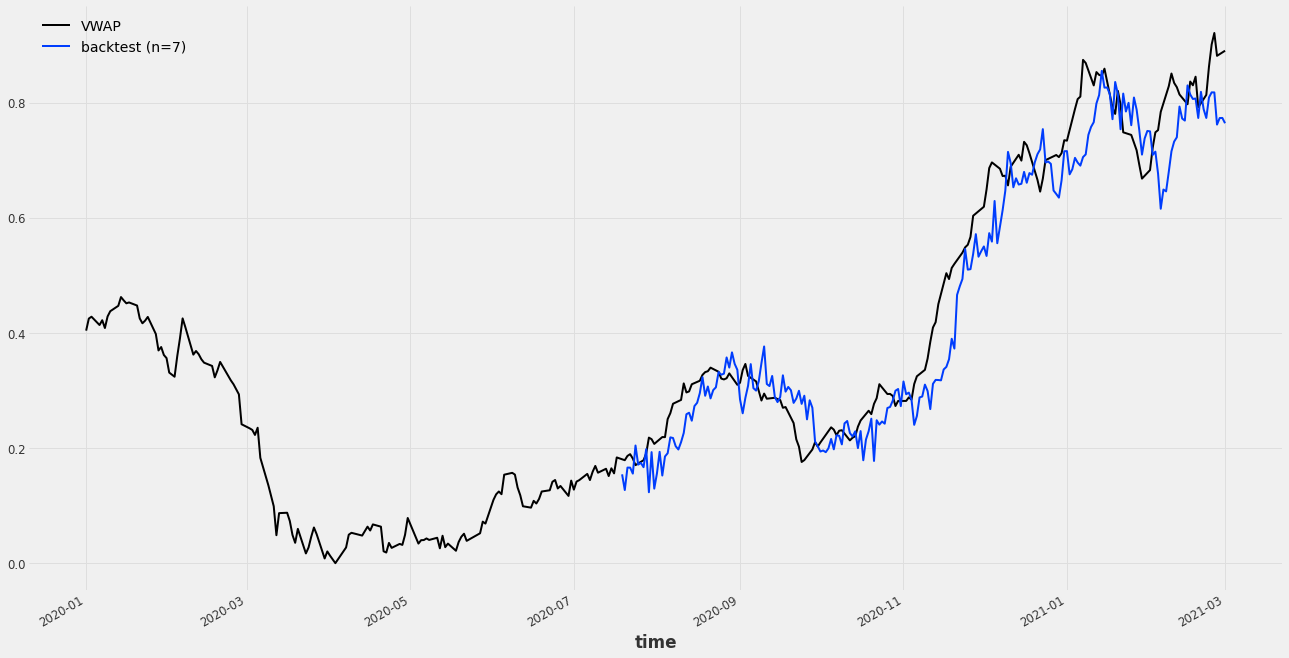

In [33]:
train_transformed[-len(backtest) - 200:].plot()
backtest.plot(label='backtest (n=7)')

print('Backtest RMSE = {}'.format(np.round( rmse(train_transformed, backtest) )))

Now that we have seen how to evaluate individual models, the next step is fairly natural:


## Ensembling

In [34]:
from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
from darts.datasets import AirPassengersDataset

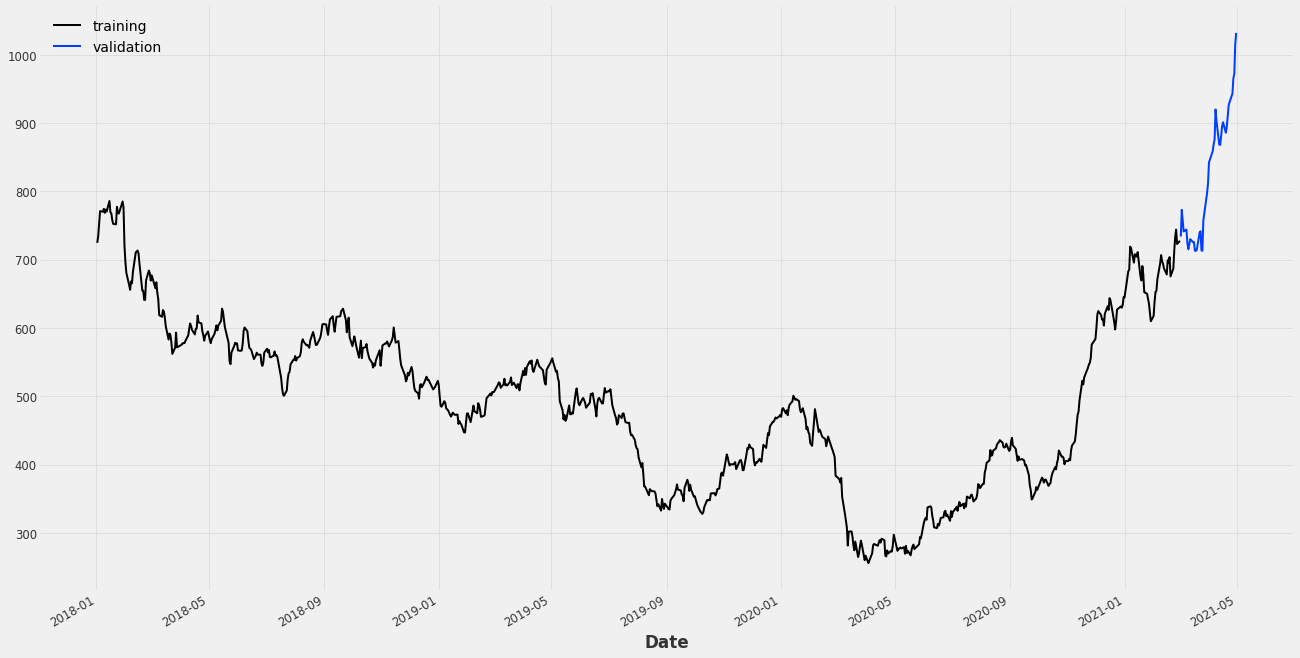

In [35]:
# prepare the data
df = pd.read_csv('../input/nifty50-stock-market-data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
df = df.loc[df.Date > CFG.cutoff]

series = TimeSeries.from_dataframe(df, 'Date', 'VWAP', freq = 'D')
series = fill_missing_values(series)

# split into training / validation
train, val = series[:-60], series[-60:]

train.plot(label='training')
val.plot(label='validation')
plt.legend();

In [36]:

from functools import reduce
from darts.models import NaiveSeasonal, NaiveDrift

# define the list of models we use 

models = [# NaiveSeasonal(6), 
          AutoARIMA(),
          # NaiveDrift(),
          Theta(),
          # ExponentialSmoothing(),
          Prophet()
         ]


# create the backtests for the individual models
model_predictions = [m.historical_forecasts(series, 
                                            # start of the backtesting period for the individual models
                                            start=pd.Timestamp('2020-01-01'), 
                                            forecast_horizon=12, 
                                            stride=12, 
                                            last_points_only=False,
                                            verbose=True)
                     for m in models]

model_predictions = [reduce((lambda a, b: a.append(b)), model_pred) for model_pred in model_predictions]


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

13:51:00 - cmdstanpy - INFO - Chain [1] start processing
13:51:00 - cmdstanpy - INFO - Chain [1] done processing
13:51:01 - cmdstanpy - INFO - Chain [1] start processing
13:51:01 - cmdstanpy - INFO - Chain [1] done processing
13:51:02 - cmdstanpy - INFO - Chain [1] start processing
13:51:02 - cmdstanpy - INFO - Chain [1] done processing
13:51:03 - cmdstanpy - INFO - Chain [1] start processing
13:51:03 - cmdstanpy - INFO - Chain [1] done processing
13:51:04 - cmdstanpy - INFO - Chain [1] start processing
13:51:04 - cmdstanpy - INFO - Chain [1] done processing
13:51:05 - cmdstanpy - INFO - Chain [1] start processing
13:51:05 - cmdstanpy - INFO - Chain [1] done processing
13:51:06 - cmdstanpy - INFO - Chain [1] start processing
13:51:06 - cmdstanpy - INFO - Chain [1] done processing
13:51:07 - cmdstanpy - INFO - Chain [1] start processing
13:51:07 - cmdstanpy - INFO - Chain [1] done processing
13:51:08 - cmdstanpy - INFO - Chain [1] start processing
13:51:08 - cmdstanpy - INFO - Chain [1]

In [37]:
model_predictions_stacked = model_predictions[0]
for model_prediction in model_predictions[1:]:
    model_predictions_stacked = model_predictions_stacked.stack(model_prediction)

With historical forecasts calculated through backtesting, we can move towards training an ensemble model combining our component series. 

In [38]:
# setup our ensembling model
regr_model = RegressionModel(lags=None, lags_future_covariates=[0], 
                             # anything with .fit and .predict methods from sklearn will do here - LinearRegression by default
                             model= Ridge()
                            )

# adjust index on the target series
series_target = series.slice_intersect(model_predictions[0])


In [39]:
# backtest for the RegressionModel 
ensemble_pred = regr_model.historical_forecasts(
    series=series_target, future_covariates=model_predictions_stacked, 
    # start of the calibration periods for the ensemble 
    start=pd.Timestamp('2020-06-01'), 
    forecast_horizon=3, verbose=True
)

  0%|          | 0/326 [00:00<?, ?it/s]

Finally, let's see how good the regression performs, compared to the original forecasts:


Regression coefficients for the individual models:
Learned coefficient for Auto-ARIMA: 0.95
Learned coefficient for Theta(2): 0.16
Learned coefficient for Prophet: -0.10


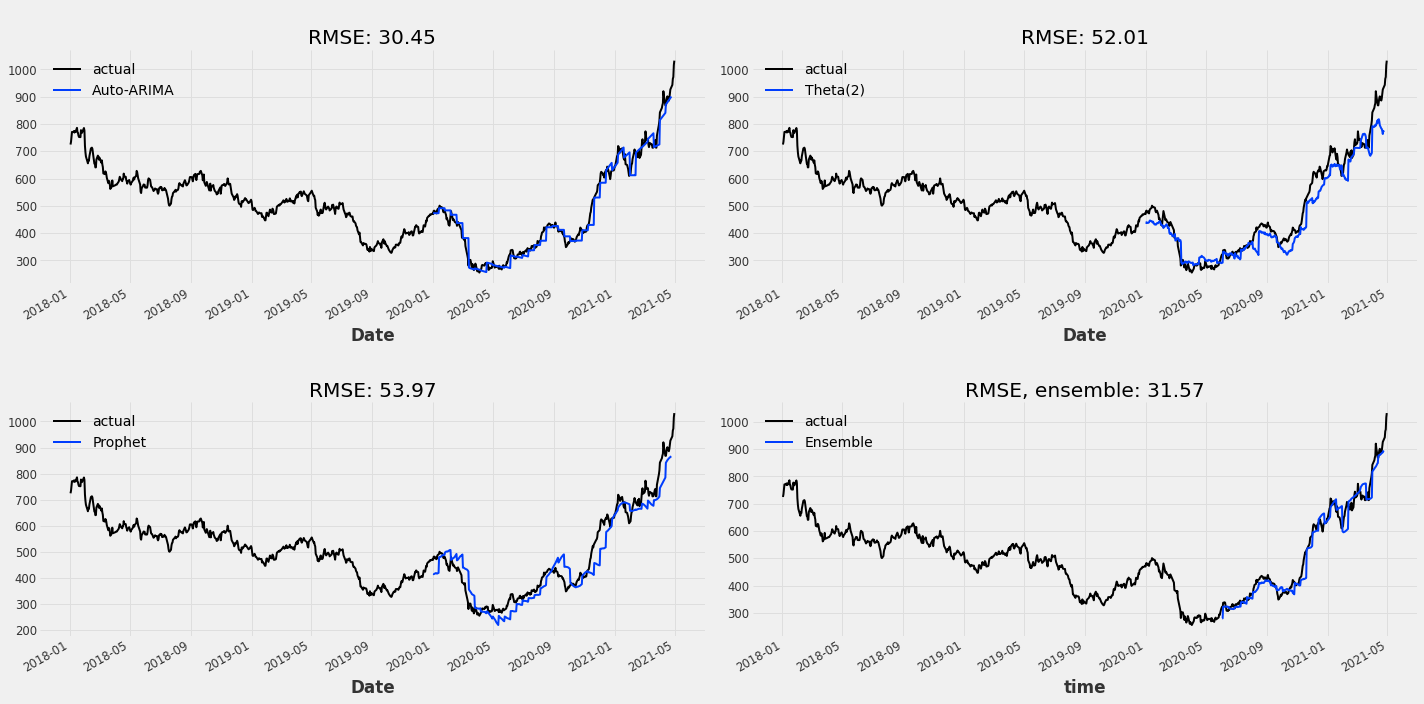

In [40]:
import darts.metrics as dme
def muh_rmse(x,y):
    return np.round(np.sqrt(dme.mse(x,y)) ,2)

fig, ax = plt.subplots(2,2,figsize=(CFG.img_dim1,CFG.img_dim2))
ax = ax.ravel()

for i, m in enumerate(models):
    series.plot(label='actual', ax=ax[i])
    model_predictions[i].plot(label=str(m), ax=ax[i])
    
    # intersect last part, to compare all the methods over the duration of the ensemble forecast
    model_pred = model_predictions[i].slice_intersect(ensemble_pred)
       
    # model_error = mape(series, model_pred)
    model_error = muh_rmse(series, model_pred)
    ax[i].set_title('\nRMSE: {:.2f}'.format(model_error))
    ax[i].legend()

series.plot(label='actual', ax=ax[3])
ensemble_pred.plot(label='Ensemble', ax=ax[3])
ax[3].set_title('\nRMSE, ensemble: {:.2f}'.format(muh_rmse(series, ensemble_pred)))
ax[3].legend()

print('\nRegression coefficients for the individual models:')
for i, m in enumerate(models):
    print('Learned coefficient for {}: {:.2f}'.format(m, regr_model.model.coef_[i]))
plt.tight_layout();

`Darts` takeaway:
* multiple models - statistics, DL, hybrid
* backstesting
* ensembling 
* **transfer learning**


<a id="section-three"></a>
# Kats

Facebook Research unit made its first appearance in this series thanks to Prophet, but it is far from their only contribution to time series - recently they released their own one-stop-shop in the form of `Kats`: https://facebookresearch.github.io/Kats/. The elevator pitch for `Kats` contains it with  generic analysis, forecasting, anomaly detection, multivariate analysis, and feature extraction/embedding. An interesting feature is that it incorporates both vintage methods like ARIMA and modern ones (based on LSTM). 


Kats implements an ensembling solution just like `darts` (choosing an implementation is a YMMV type of situation), but their take on backtesting has useful metrics info not available - at least not so easily - in darts.

In [41]:
!pip install llvmlite --ignore-installed

  Using cached llvmlite-0.39.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.6 MB)


In [42]:
!pip install kats

     |████████████████████████████████| 612 kB 908 kB/s            
     |████████████████████████████████| 9.5 MB 36.4 MB/s            
     |████████████████████████████████| 361 kB 62.2 MB/s            
     |████████████████████████████████| 950 kB 40.4 MB/s            
     |████████████████████████████████| 347 kB 65.1 MB/s            
     |████████████████████████████████| 776.3 MB 7.5 kB/s              
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1+cpu
    Uninstalling torch-1.9.1+cpu:
      Successfully uninstalled torch-1.9.1+cpu
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.7
    Uninstalling cmdstanpy-1.0.7:
      Successfully uninstalled cmdstanpy-1.0.7
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.2
    Uninstalling statsmodels-0.13.2:
      Successfully uninstalled statsmodels-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the package

In [43]:
from kats.models.prophet import ProphetModel, ProphetParams
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel
from kats.models.arima import ARIMAModel, ARIMAParams

from kats.utils.backtesters import BackTesterSimple


<AxesSubplot:xlabel='ds'>

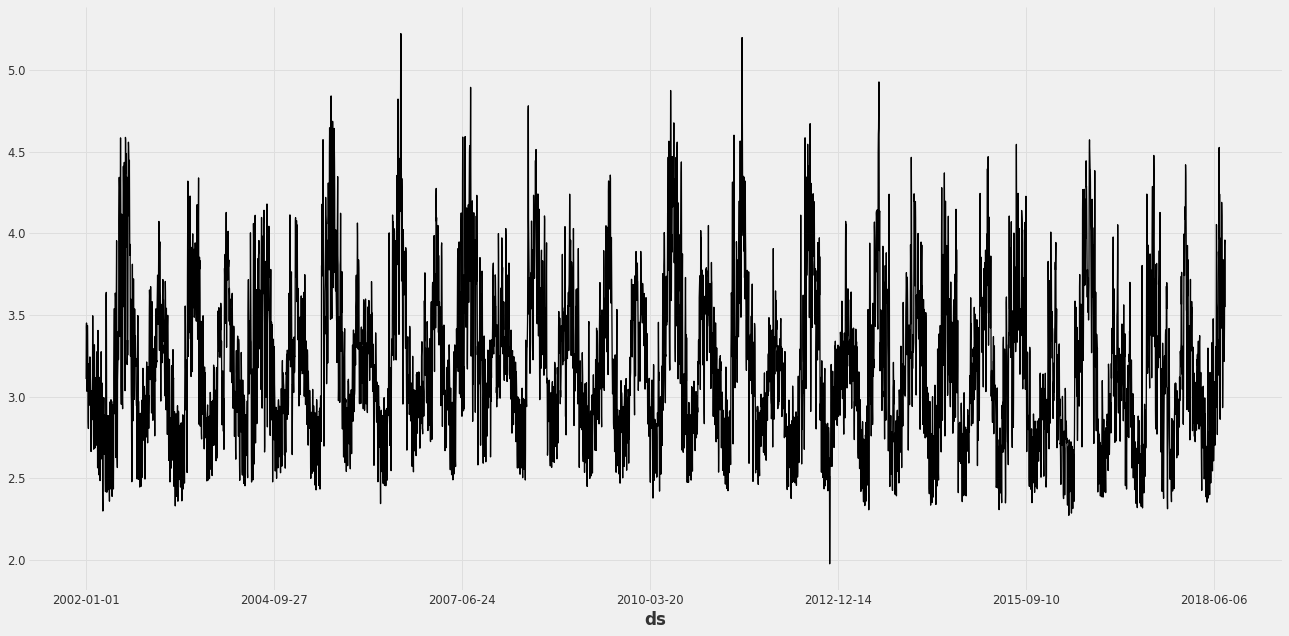

In [44]:
# stock_name = 'AXISBANK'
# df = pd.read_csv('../input/nifty50-stock-market-data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
# df = df.loc[df.Date > CFG.cutoff]
# NAs strike again :-( 

# df.set_index("Date").VWAP.plot()
df = pd.read_csv(CFG.data_folder + 'energy_daily.csv')
df['y'] = df['y'] / 10**4
df.set_index("ds").y.plot()


In [45]:
# prepare into Kats format
from kats.consts import TimeSeriesData
df.columns = ["time", "value"]
df['time'] = pd.to_datetime(df['time'])
df_ts = TimeSeriesData(df, time_col_name="time")

In [46]:
backtester_errors = {}

# specify the metrics we are interested in
ALL_ERRORS = ['mape', 'smape', 'mae', 'mase', 'mse', 'rmse']

In [47]:
!wget https://raw.githubusercontent.com/facebookresearch/Kats/main/kats/data/air_passengers.csv

--2022-09-30 13:54:00--  https://raw.githubusercontent.com/facebookresearch/Kats/main/kats/data/air_passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2165 (2.1K) [text/plain]
Saving to: ‘air_passengers.csv’

air_passengers.csv  100%[===================>]   2.11K  --.-KB/s    in 0s      

2022-09-30 13:54:00 (22.2 MB/s) - ‘air_passengers.csv’ saved [2165/2165]



In [48]:
air_passengers_df = pd.read_csv("air_passengers.csv")
air_passengers_df.columns = ["time", "value"]
air_passengers_ts = TimeSeriesData(air_passengers_df)


ARIMA model:

In [49]:

params = ARIMAParams(p=2, d=1, q=1)

backtester_arima = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data= df_ts,
    params=params,
    train_percentage=75,
    test_percentage=25, 
    model_class=ARIMAModel)

backtester_arima.run_backtest()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11243D-01    |proj g|=  6.74483D-04


 This problem is unconstrained.



At iterate    5    f= -1.11243D-01    |proj g|=  2.37838D-05

At iterate   10    f= -1.11243D-01    |proj g|=  4.02456D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     17      1     0     0   4.025D-08  -1.112D-01
  F = -0.11124308881896142     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [50]:
# store the errors in the dictionary
backtester_errors['arima'] = {}
for error, value in backtester_arima.errors.items():
    backtester_errors['arima'][error] = value

Prophet:

In [51]:
params_prophet = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

backtester_prophet = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=df_ts,
    params=params_prophet,
    train_percentage=75,
    test_percentage=25, 
    model_class=ProphetModel)

backtester_prophet.run_backtest()



Initial log joint probability = -20.9939
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       11090.3    0.00165389       577.061       0.529      0.0529      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       11095.5    0.00024535       170.514      0.5866      0.5866      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220         11096   4.15773e-05       122.698   4.722e-07       0.001      315  LS failed, Hessian reset 
     273       11096.2   0.000881586       180.985   1.274e-05       0.001      425  LS failed, Hessian reset 
     299       11096.3   1.76647e-05        60.376           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       11096.8     0.0046165       111.037           1           1      578   
    Iter      log pro

In [52]:
backtester_errors['prophet'] = {}
for error, value in backtester_prophet.errors.items():
    backtester_errors['prophet'][error] = value

Exponential smoothing:


In [53]:
params_hw = HoltWintersParams(trend = 'additive') # additive mode gives worse results

backtester_hw = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=df_ts,
    params=params_hw,
    train_percentage=75,
    test_percentage=25, 
    model_class=HoltWintersModel)

backtester_hw.run_backtest()


In [54]:
backtester_errors['hw'] = {}
for error, value in backtester_hw.errors.items():
    backtester_errors['hw'][error] = value

Combine the results:


In [55]:
pd.DataFrame.from_dict(backtester_errors)

arima   prophet        hw
mape   0.121647  0.090782  0.177421
smape  0.122287  0.087633  0.159740
mae    0.386234  0.280980  0.512785
mase   2.081322  1.514136  2.763277
mse    0.226690  0.120199  0.354846
rmse   0.476120  0.346697  0.595689

`Kats` takeaway:
* multiple models - statistics, DL, hybrid (but fewer than darts)
* backstesting - more metrics
* ensembling 
* global model!


Don't say goodbye to `darts` and `Kats` just yet - we will meet them in again, in the episode dedicated to meta learning and transfer learning for time series. 

<a id="section-four"></a>
# Bonus track: GluonTS

For some inexplicable reason, `GluonTS` escaped my attention when I was writing this episode - but if a rock band can release a new version of an album with extra material, so can I :-) GluonTS is a library for probabilistic time series modeling, focusing on deep learning; while there are numerous libraries utilizing DL (including some desribed above), it's the probabilistic part that makes Gluon truly stand out (well, and the fact they are one of a few environments left that keep the torch burning for `MXNet`). In this section, we will take Gluon for a test drive.

In [56]:
!pip install --upgrade mxnet==1.6.0
!pip install gluonts

     |████████████████████████████████| 68.7 MB 118 kB/s             
  Attempting uninstall: mxnet
    Found existing installation: mxnet 1.9.0
    Uninstalling mxnet-1.9.0:
      Successfully uninstalled mxnet-1.9.0
     |████████████████████████████████| 2.5 MB 779 kB/s            


`GluonTS` comes with several DL models - full list of references (including source papers) is available in the official documentation https://github.com/awslabs/gluon-ts:

- DeepAR
- DeepState
- DeepFactor
- Deep Renewal Processes
- GPForecaster
- MQ-CNN
- MQ-RNN
- N-BEATS
- Rotbaum
- Causal Convolutional Transformer
- Temporal Fusion Transformer
- Transformer
- WaveNet
- SimpleFeedForward
- DeepVAR
- GPVAR
- LSTNet
- DeepTPP
- RForecast
- Prophet
- NaiveSeasonal
- Naive2
- NPTS



We will demonstrate Gluon capabilities by using DeepAR: an algorithm developed by Amazon Research that builds probabilistic forecasts for multiple time series using LSTM architecture as a basis (see the RNN episode for a refresher on LSTM https://www.kaggle.com/code/konradb/ts-6-deep-learning-for-ts-rnn-and-friends). TL;DR summary of the Amazon twist is that encoder and decoder networks share the same architecture:

[source](https://towardsdatascience.com/prophet-vs-deepar-forecasting-food-demand-2fdebfb8d282)

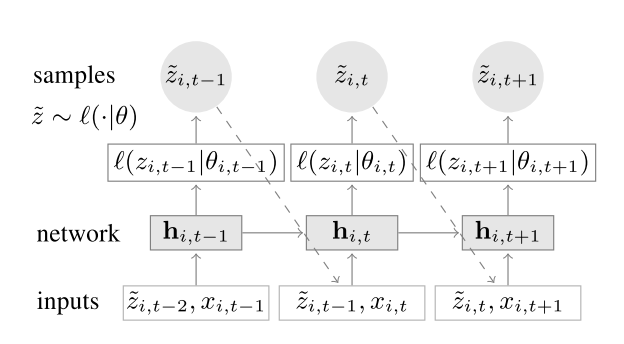

Main features of Deep AR:

- incorporation of covariates 

- a categorical variables specifying grouping of the related time series (models train an embedding vector that learns the common properties of all the time series in the group)

- automatic creation of additional feature time series, depending on the granularity of the target time series (e.g. indicators for day of week, month of year etc)

- MC sampling for distibutional properties inference 

- **Built-in item supersession**: It can predict on items with little history items by learning from similar items

We will use [dataset](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption) on hourly energy consumption from across different regions in the US - due to regional variation, the patterns can differ substantially $\implies$ a single model handling them jointly has potential business value.


In [57]:
# setup the data and align the lengths for simplicity

df1 = pd.read_csv("../input/hourly-energy-consumption/COMED_hourly.csv",parse_dates = True)
df1 = df1.loc[df1["Datetime"] > '2011-12-31'].reset_index(drop = True)
df2 = pd.read_csv("../input/hourly-energy-consumption/DOM_hourly.csv",parse_dates = True)
df2 = df2.loc[df2["Datetime"] > '2011-12-31'].reset_index(drop = True)
df3 = pd.read_csv("../input/hourly-energy-consumption/PJME_hourly.csv",parse_dates = True)
df3 = df3.loc[df3["Datetime"] > '2011-12-31'].reset_index(drop = True)


# (minor) DeepAR kink: convert everything long -> wide
def format_df(df):
    xname = df.columns[1][:-3]
    df = df.T
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])
    df['Station_Name'] = xname
    df = df.reset_index(drop = True)

    return df


df1 = format_df(df1)
df2 = format_df(df2)
df3 = format_df(df3)


# combine
df_all = pd.concat([df1 , df2, df3] , axis = 0 )
df_all = df_all.set_index("Station_Name")
df_all = df_all.reset_index()


# grouping variable for using with DeepAR
ts_code=df_all['Station_Name'].astype('category').cat.codes.values
ts_code

array([0, 1, 2], dtype=int8)

In [58]:
# train / test split
freq="1H"
start_train = pd.Timestamp("2011-12-31 01:00:00", freq=freq) 
start_test = pd.Timestamp("2016-06-10 18:00:00", freq=freq) 

prediction_lentgh= 24 * 1 

df_train=df_all.iloc[:,1:40000].values
df_test=df_all.iloc[:,40000:].values

Just like every other library discussed in this notebook, `GluonTS` has its own class for handling time series datasets:

In [59]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_train,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip(df_train,
                             ts_code.reshape(-1,1))
], freq=freq)

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_test,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip(df_test,
                            ts_code.reshape(-1,1))
], freq=freq)

After this (admittedly slightly longer than in previous cases ;-) preparation work, we can define our model - we give explanation for the DeepAR-specific parameters, as the rest is fairly standard for RNN / LSTM modeling:

In [60]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(freq=freq, 
                            context_length=24 * 5, 
                            prediction_length = prediction_lentgh,
                            # indicator variable to tell our model which time series observation is which
                            # see ts_code above                                                                
                            use_feat_static_cat=True,
                            # While making predictions we are only using the returns observation for each item month wise and no other extra features , 
                            # hence cardinality of 1
                            cardinality=[1],
                            num_layers=2,
                            num_cells=32,
                            cell_type='lstm',
                            dropout_rate = 0.25,
                            trainer=Trainer(epochs= 10 , learning_rate=1e-3  ,batch_size = 512, patience = 5 ))

Training the model is not a challenge to anybody familiar with the `scikit-learn` way of doing things:

In [61]:
predictor = estimator.train(training_data=train_ds)


100%|██████████| 50/50 [00:52<00:00,  1.05s/it, epoch=10/10, avg_epoch_loss=7.69]


Generating predictions works in a manner slightly similar to Prophet: we need to generate MC samples to get at confidence intervals

In [62]:
from gluonts.evaluation.backtest import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  
    predictor=predictor,  
    num_samples=100, 
)


from tqdm.autonotebook import tqdm

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(df_test)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(df_test)))

Obtaining time series conditioning values ...


  0%|          | 0/3 [00:00<?, ?it/s]

Obtaining time series predictions ...


  0%|          | 0/3 [00:00<?, ?it/s]

In [63]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_lentgh
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

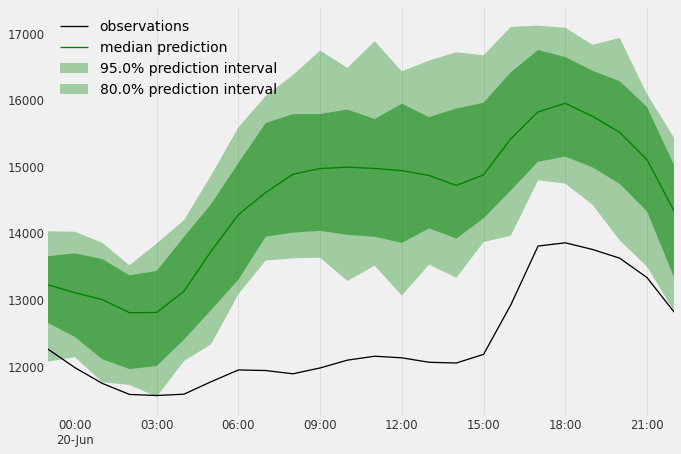

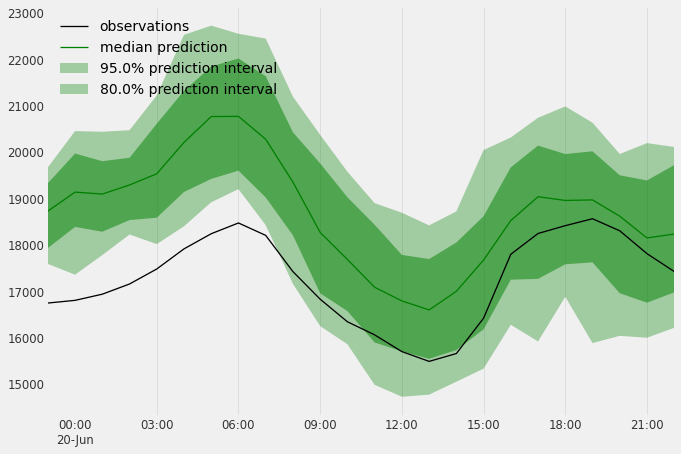

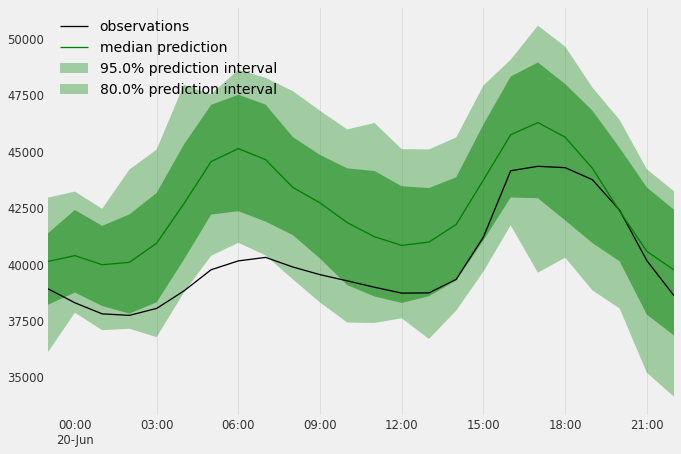

In [64]:
for i in tqdm(range(3)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry)

In [65]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(df_test))

Running evaluation: 100%|██████████| 3/3 [00:00<00:00, 29.49it/s]


In [66]:
agg_metrics

{'MSE': 4733938.222222222,
 'abs_error': 141644.9765625,
 'abs_target_sum': 1674826.0,
 'abs_target_mean': 23261.47222222222,
 'seasonal_error': 1312.4984854471224,
 'MASE': 1.7809562634236205,
 'MAPE': 0.10469170411427815,
 'sMAPE': 0.09770632121298047,
 'MSIS': 21.663151971068313,
 'QuantileLoss[0.1]': 101912.79902343752,
 'Coverage[0.1]': 0.6805555555555555,
 'QuantileLoss[0.5]': 141644.9775390625,
 'Coverage[0.5]': 0.9861111111111112,
 'QuantileLoss[0.9]': 48706.07460937499,
 'Coverage[0.9]': 1.0,
 'RMSE': 2175.761526965265,
 'NRMSE': 0.09353498807726839,
 'ND': 0.08457295060054,
 'wQuantileLoss[0.1]': 0.06084978321535343,
 'wQuantileLoss[0.5]': 0.08457295118362296,
 'wQuantileLoss[0.9]': 0.029081274478289083,
 'mean_absolute_QuantileLoss': 97421.28372395835,
 'mean_wQuantileLoss': 0.05816800295908849,
 'MAE_Coverage': 0.38888888888888884,
 'OWA': nan}

In [67]:
item_metrics

item_id           MSE     abs_error  abs_target_sum  abs_target_mean  \
0    None  4.886468e+06  50800.789062        297067.0     12377.791667   
1    None  2.479662e+06  34356.863281        414494.0     17270.583333   
2    None  6.835684e+06  56487.324219        963265.0     40136.041667   

   seasonal_error      MASE      MAPE     sMAPE        ND       MSIS  \
0      777.236948  2.723365  0.171579  0.156838  0.171008  45.215881   
1      909.647006  1.573727  0.083216  0.079182  0.082889  15.066749   
2     2250.611503  1.045777  0.059280  0.057099  0.058642   4.706826   

   QuantileLoss[0.1]  Coverage[0.1]  QuantileLoss[0.5]  Coverage[0.5]  \
0       55703.826563       1.000000       50800.790039       1.000000   
1       23349.451367       0.625000       34356.863281       1.000000   
2       22859.521094       0.416667       56487.324219       0.958333   

   QuantileLoss[0.9]  Coverage[0.9]  
0       13990.812891            1.0  
1       12043.850781            1.0  
2       22671.410937            1.0